# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [51]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [52]:
data = pd.read_csv("baseCVsJava.csv")

In [53]:
data

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,spanish
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,4,1,101,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,29,0,0,0,0,0,1,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,354,0,0,0,1,0,0
300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,10,0,0,0,0,1,0,0,0
301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,7,1,551,0,0,1,0,0,0
302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,47,1,12,0,0,0,0,0,0


### Descriptivo de la base

In [54]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Education_Level_associate        304 non-null    float64
 1   Education_Level_bachelor         304 non-null    float64
 2   Education_Level_diploma          304 non-null    float64
 3   Education_Level_master           304 non-null    float64
 4   Education_Level_phd              304 non-null    float64
 5   Education_Level_unknown          304 non-null    float64
 6   Job_Title_architect              304 non-null    float64
 7   Job_Title_developer              304 non-null    float64
 8   Job_Title_engineer               304 non-null    float64
 9   Job_Title_manager                304 non-null    float64
 10  Job_Title_unknown                304 non-null    float64
 11  Total_Word_Count                 304 non-n

### División de la base en Train y Test

In [55]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (212, 37)
Forma de x_test: (92, 37)
Forma de y_train: (212,)
Forma de y: (92,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [57]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 700}
Precisión: 0.6195652173913043
Precisión: 0.45454545454545453
Recuperación: 0.14705882352941177
Puntuación F1: 0.2222222222222222
AUC ROC: 0.5159736308316429
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75        58
           1       0.45      0.15      0.22        34

    accuracy                           0.62        92
   macro avg       0.55      0.52      0.49        92
weighted avg       0.57      0.62      0.55        92


Ranking de variables por importancia de Random Forest:
Education_Word_Count               0.100131
Work_Experience_Word_Count         0.097337
Total_Word_Count                   0.096074
Keyword_Ratio                      0.095877
Keyword_Count                      0.085604
Professional_Profile_Word_Count    0.081694
Skills_Word_Count                  0.080607
projects_Word_

In [58]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
Job_Title_manager                  0.047307
projects_Word_Count                0.040093
Professional_Profile_Word_Count    0.031143
Achievements_Word_Count            0.028302
Pages                              0.024813
Job_Title_developer                0.023833
Achievements_Exists                0.018335
french                             0.010923
Education_Level_phd                0.010540
Skills_Word_Count                  0.002315
Education_Level_bachelor           0.000932
Job_Title_architect                0.000296
Skills_Exists                      0.000000
Projects_Exists                    0.000000
volunteer_work_Exists              0.000000
Professional_Profile_Exists        0.000000
volunteer_work_Word_Count          0.000000
english                            0.000000
Certifications_Word_Count          0.000000
Certifications_Exists              0.000000
Education_Level_associate          0.000000
Education_Word_Count            

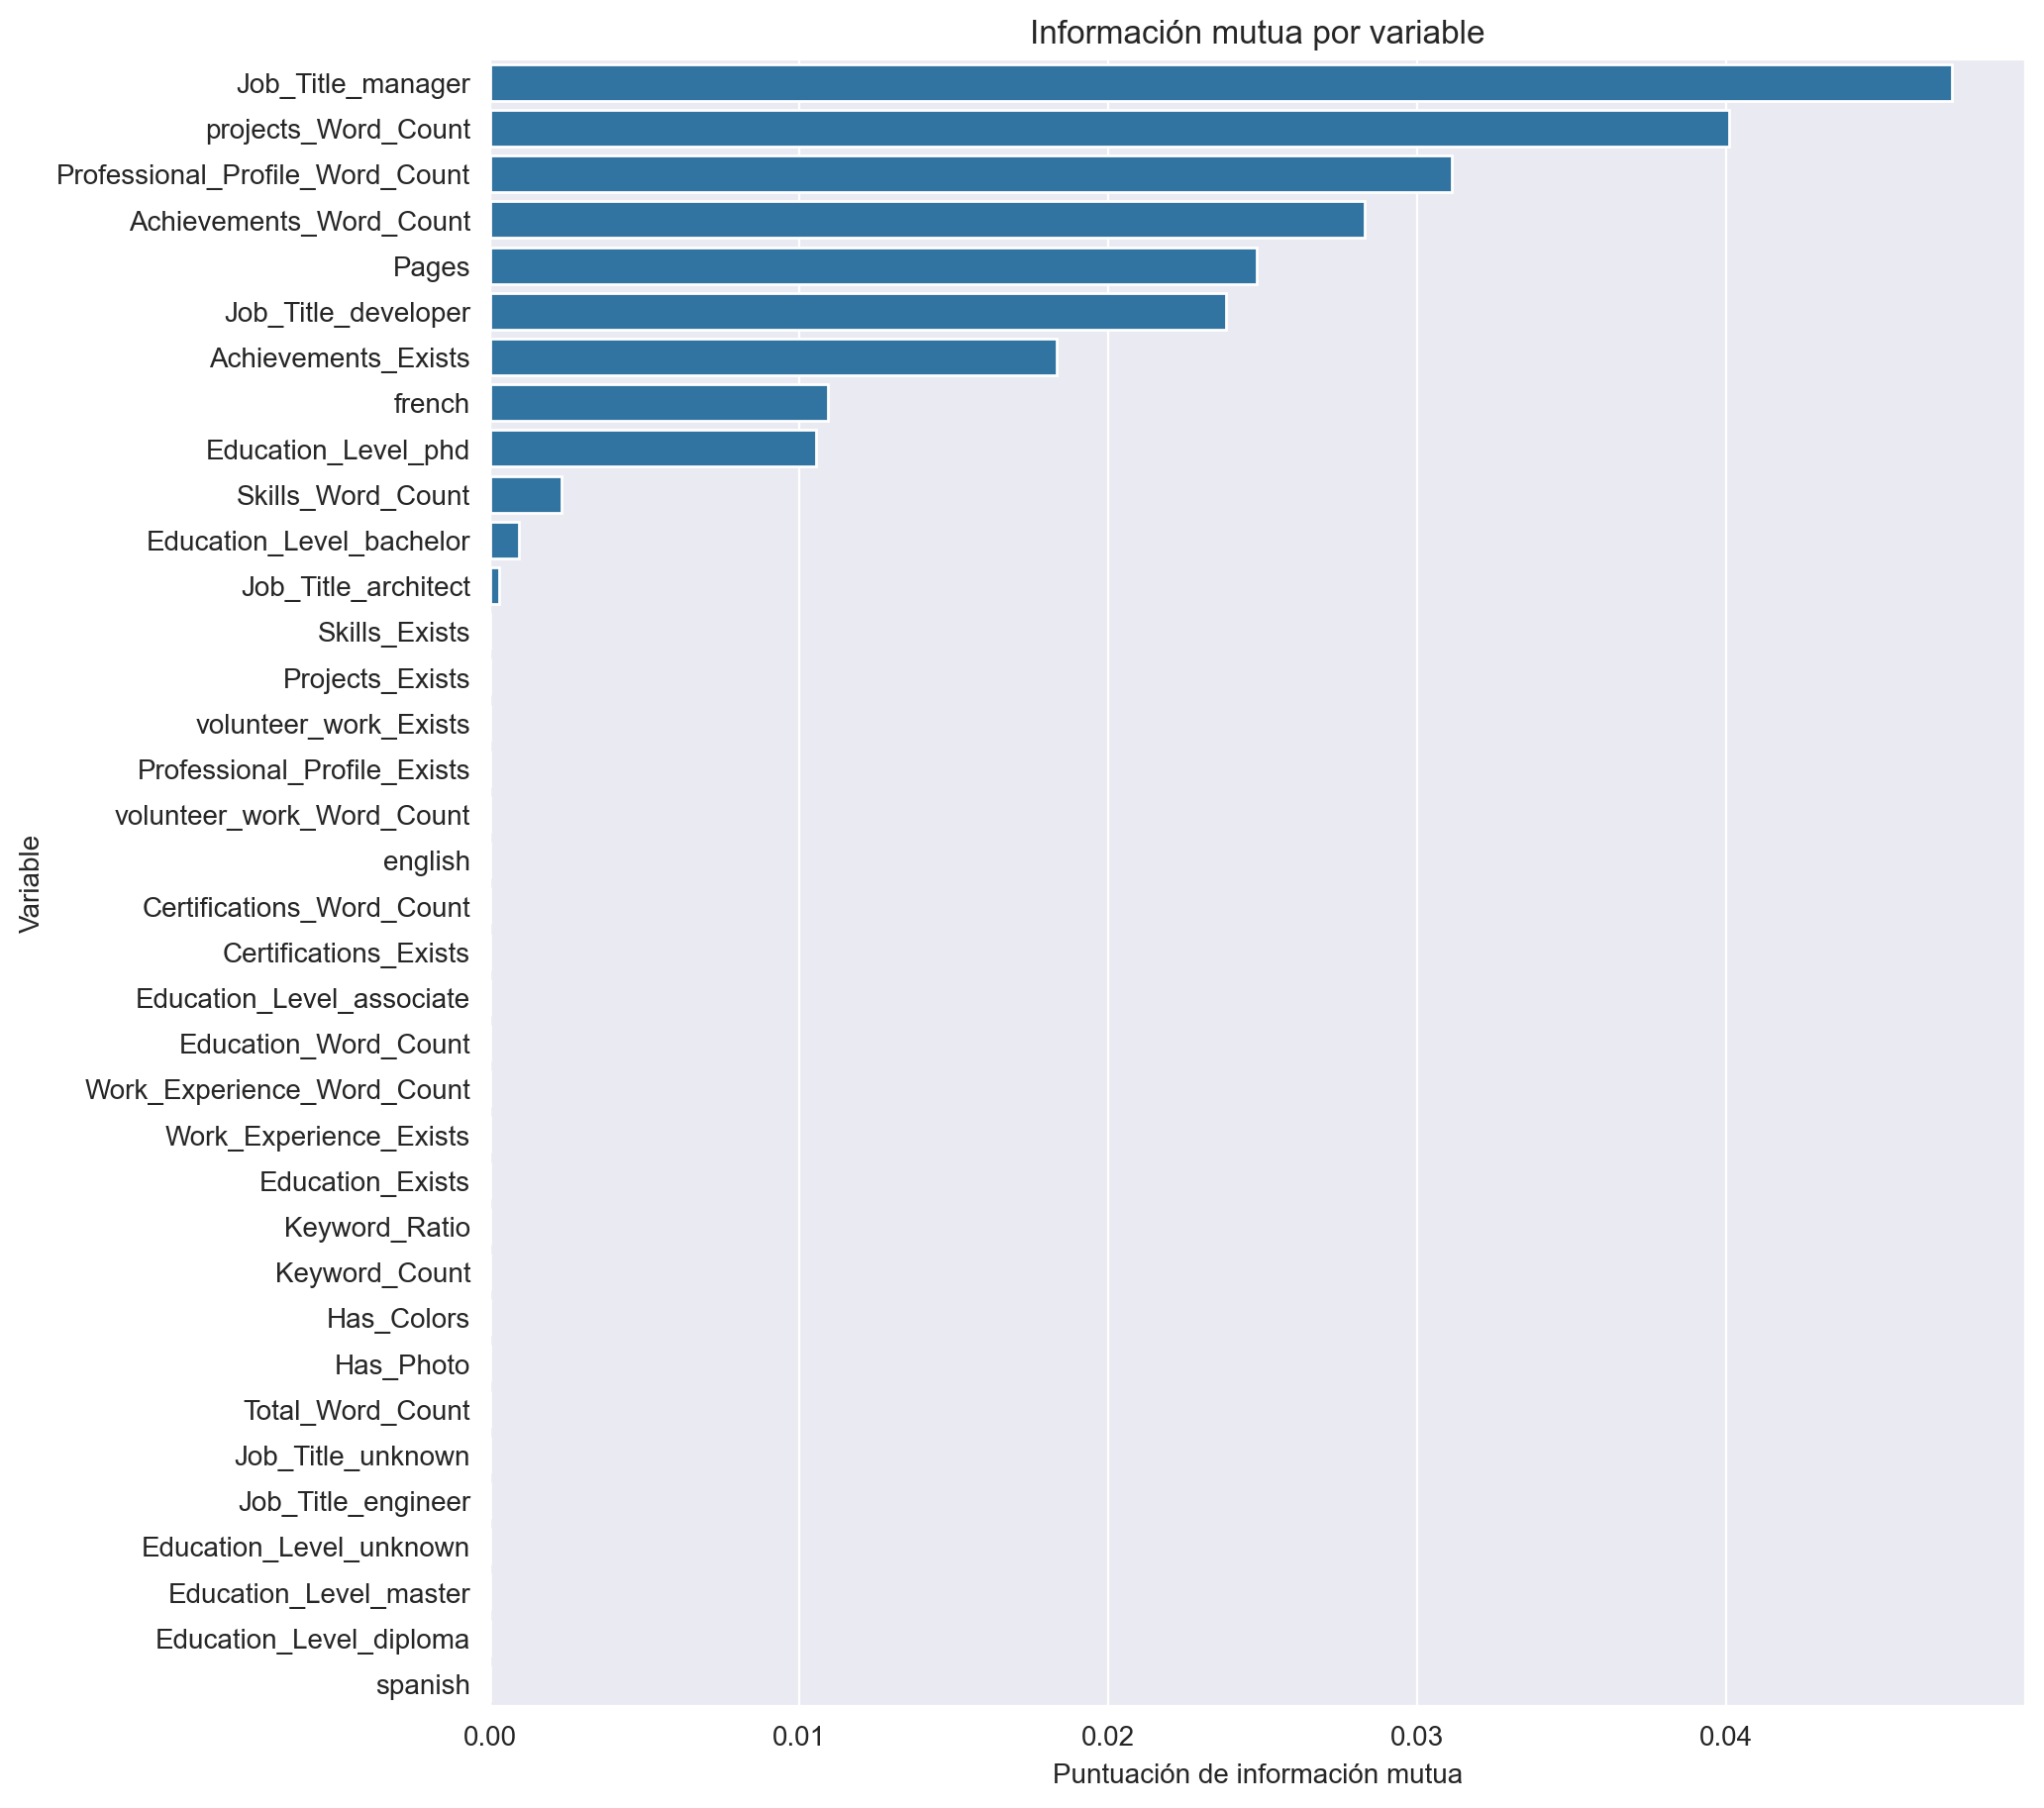

In [59]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [61]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Precisión: 0.6304347826086957
Precisión: 0.5
Recuperación: 0.20588235294117646
Puntuación F1: 0.2916666666666667
AUC ROC: 0.543103448275862
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.88      0.75        58
           1       0.50      0.21      0.29        34

    accuracy                           0.63        92
   macro avg       0.58      0.54      0.52        92
weighted avg       0.60      0.63      0.58        92

Acierto en el conjunto de entrenamiento: 63.68(%)
Acierto en el conjunto de test: 63.04(%)
Variables seleccionadas: Index(['Education_Level_bachelor', 'Education_Level_master',
       'Education_Level_unknown', 'Job_Title_engineer', 'Skills_Exists',
       'Certifications_Exists', 'Certifications_Word_Count',
       'Professional_Profile_Exists', 'Professional_Profile_Word_Count',
       'Projects_Exists

## Agregar variables al modelo


In [62]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['Professional_Profile_Word_Count', 'Education_Word_Count', 'spanish', 'Job_Title_engineer', 'Professional_Profile_Exists', 'Work_Experience_Exists', 'Job_Title_architect', 'Job_Title_developer', 'Job_Title_manager', 'Job_Title_unknown', 'Education_Level_phd', 'french', 'Education_Exists', 'volunteer_work_Word_Count', 'english', 'Work_Experience_Word_Count', 'Education_Level_diploma', 'Skills_Exists', 'Achievements_Word_Count', 'Pages', 'Education_Level_bachelor', 'Total_Word_Count', 'Education_Level_associate', 'volunteer_work_Exists', 'Education_Level_unknown', 'Has_Photo', 'Education_Level_master', 'Certifications_Exists', 'Skills_Word_Count', 'Projects_Exists', 'Keyword_Ratio', 'Achievements_Exists', 'Certifications_Word_Count', 'Keyword_Count', 'projects_Word_Count', 'Has_Colors']


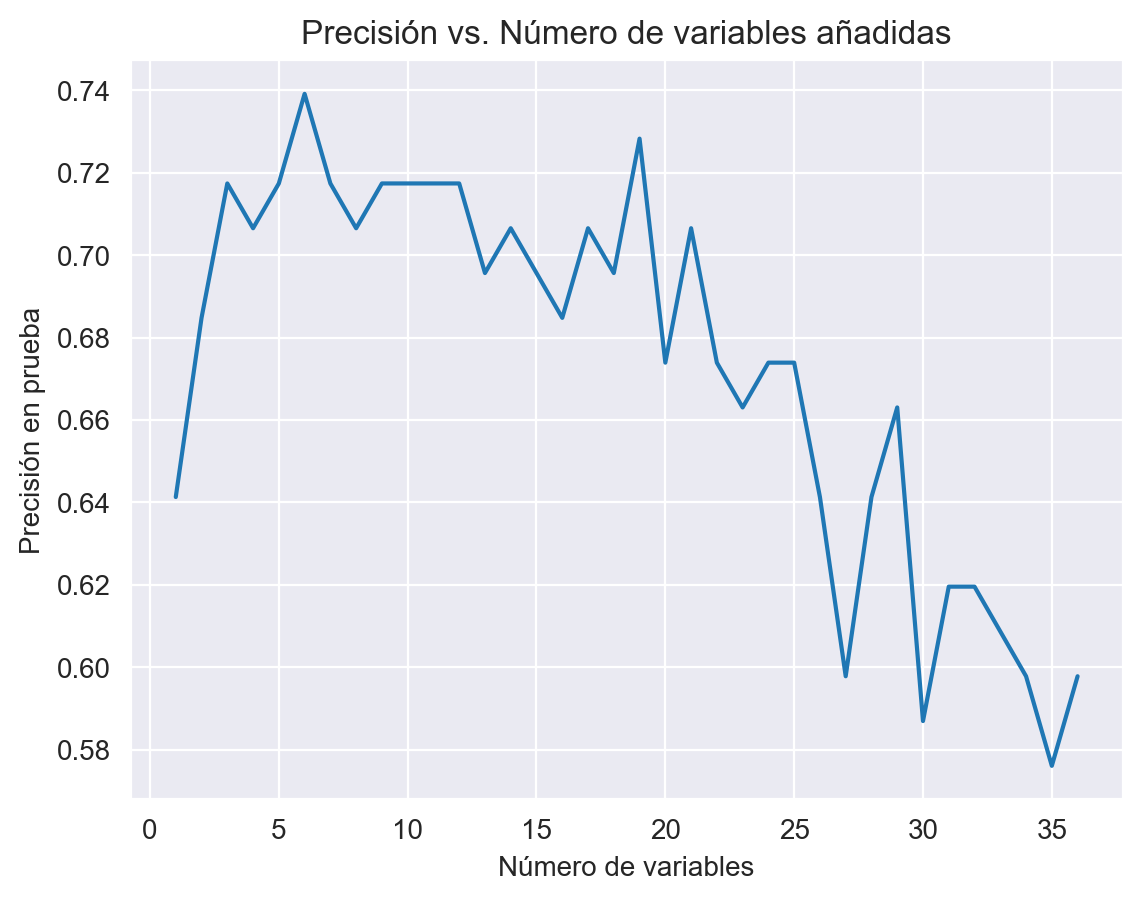

In [63]:
orden_vars_suma, precisiones_suma = agregar_variables_recursivamente(data)


### Eliminar variables de acuerdo a lo que nos mostró este resultado

In [64]:
data_modelo_sumar_variables = data.drop(['Education_Level_bachelor', 'Total_Word_Count', 'Education_Level_associate', 'volunteer_work_Exists', 'Education_Level_unknown', 'Has_Photo', 'Education_Level_master', 'Certifications_Exists', 'Skills_Word_Count', 'Projects_Exists', 'Keyword_Ratio', 'Achievements_Exists', 'Certifications_Word_Count', 'Keyword_Count', 'projects_Word_Count', 'Has_Colors'], axis=1)


In [65]:
mejores_params_suma_var, metrics_suma_var, ranking_variables_var = analizar_random_forest_optimo(data_modelo_sumar_variables)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Precisión: 0.6413043478260869
Precisión: 0.5555555555555556
Recuperación: 0.14705882352941177
Puntuación F1: 0.23255813953488372
AUC ROC: 0.6488336713995944
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.93      0.77        58
           1       0.56      0.15      0.23        34

    accuracy                           0.64        92
   macro avg       0.60      0.54      0.50        92
weighted avg       0.62      0.64      0.57        92


Ranking de variables por importancia de Random Forest:
Education_Word_Count               0.223318
Work_Experience_Word_Count         0.221513
Professional_Profile_Word_Count    0.160903
Pages                              0.143687
english                            0.043835
Professional_Profile_Exists        0.041531
Skills_Exists                      0.034846
Achievements_W

### Eliminar Variables del modelo

In [66]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Achievements_Exists', 'Keyword_Count', 'Education_Level_unknown', 'Job_Title_manager', 'Job_Title_developer', 'Total_Word_Count', 'Education_Level_bachelor', 'Keyword_Ratio', 'Education_Level_diploma', 'volunteer_work_Exists', 'Job_Title_unknown', 'Education_Word_Count', 'Certifications_Word_Count', 'Education_Level_phd', 'Education_Exists', 'Job_Title_architect', 'Professional_Profile_Word_Count', 'volunteer_work_Word_Count', 'Education_Level_master', 'Education_Level_associate', 'Work_Experience_Exists', 'Has_Colors', 'Job_Title_engineer', 'Work_Experience_Word_Count', 'Pages', 'Skills_Word_Count', 'Certifications_Exists', 'Achievements_Word_Count', 'Projects_Exists', 'Skills_Exists', 'french', 'projects_Word_Count', 'Has_Photo', 'Professional_Profile_Exists', 'english']


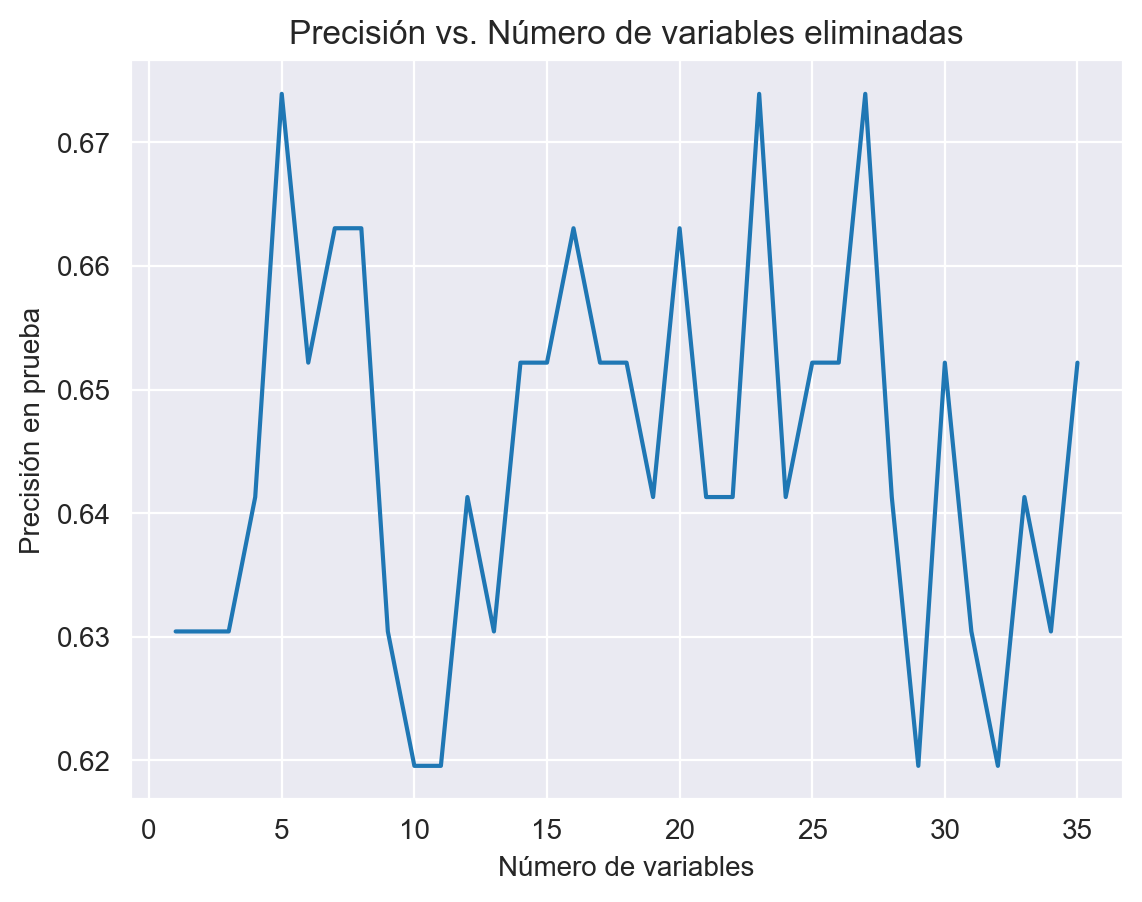

In [67]:
orden_vars_resta, precisiones_resta = eliminar_variables_recursivamente(data)

In [68]:
data_modelo_restar_variables = data.drop(['Achievements_Exists', 'Keyword_Count', 'Education_Level_unknown', 'Job_Title_manager', 'Job_Title_developer', 'Total_Word_Count', 'Education_Level_bachelor', 'Keyword_Ratio', 'Education_Level_diploma', 'volunteer_work_Exists', 'Job_Title_unknown', 'Education_Word_Count', 'Certifications_Word_Count', 'Education_Level_phd', 'Education_Exists', 'Job_Title_architect', 'Professional_Profile_Word_Count', 'volunteer_work_Word_Count', 'Education_Level_master', 'Education_Level_associate', 'Work_Experience_Exists', 'Has_Colors', 'Job_Title_engineer'], axis=1)

In [69]:
mejores_params_resta_var, metrics_resta_var, ranking_variables_resta_var = analizar_random_forest_optimo(data_modelo_restar_variables)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Precisión: 0.6304347826086957
Precisión: 0.5
Recuperación: 0.058823529411764705
Puntuación F1: 0.10526315789473684
AUC ROC: 0.5580628803245435
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.97      0.77        58
           1       0.50      0.06      0.11        34

    accuracy                           0.63        92
   macro avg       0.57      0.51      0.44        92
weighted avg       0.59      0.63      0.52        92


Ranking de variables por importancia de Random Forest:
Work_Experience_Word_Count     0.246037
Skills_Word_Count              0.184406
projects_Word_Count            0.149276
Pages                          0.146287
Professional_Profile_Exists    0.063479
english                        0.047258
Has_Photo                      0.041774
Projects_Exists                0.032258
Achievements_Wor

## Ranking de variables

In [70]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
Work_Experience_Word_Count         0.101509
Keyword_Count                      0.099265
Total_Word_Count                   0.095287
Keyword_Ratio                      0.085456
Education_Word_Count               0.084787
Skills_Word_Count                  0.083495
Professional_Profile_Word_Count    0.068848
Pages                              0.051739
projects_Word_Count                0.051624
Education_Level_master             0.020872
english                            0.019799
Professional_Profile_Exists        0.019670
Has_Colors                         0.019225
Education_Level_unknown            0.017483
Has_Photo                          0.016187
Certifications_Word_Count          0.015907
Job_Title_engineer                 0.015810
Achievements_Word_Count            0.014971
Skills_Exists                      0.013764
Job_Title_developer                0.013734
Education_Level_bachelor           0.013688
Projects_Exists      

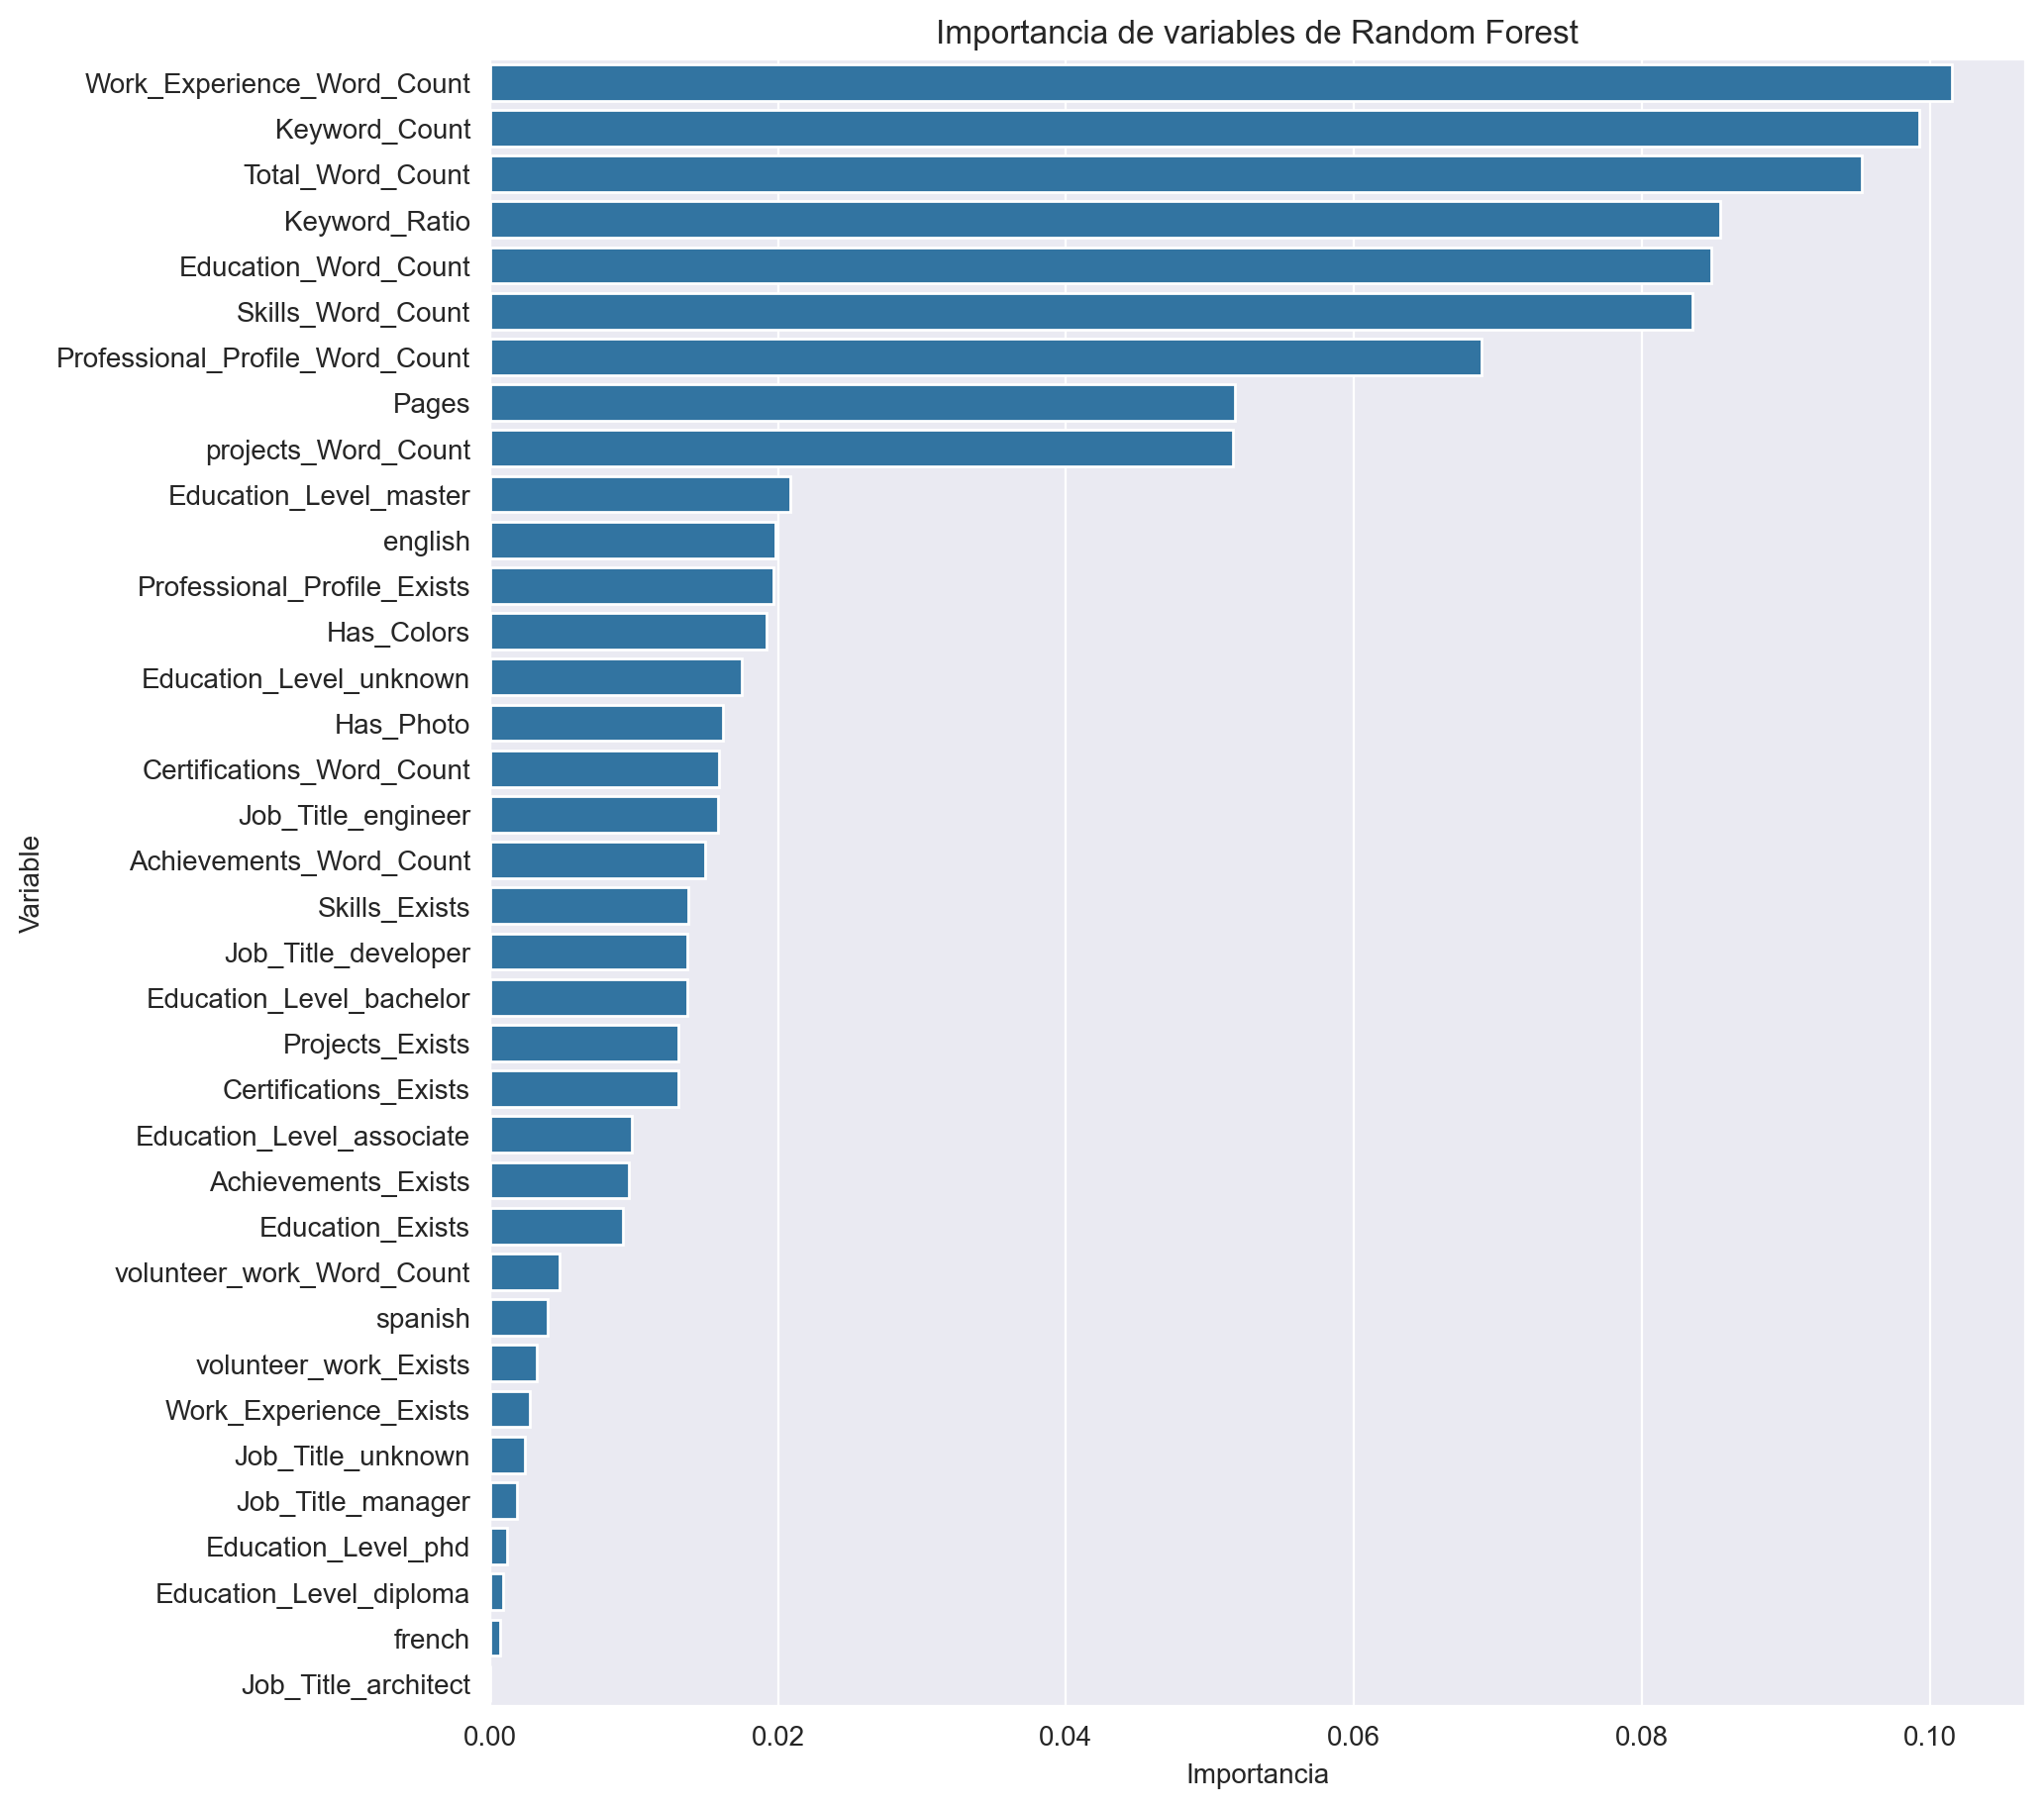

In [71]:
importancia_rf = obtener_importancia_rf(data)

# prueba con nuevo script ajustando muestra


In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 📌 Step 1: Load the dataset
df = pd.read_csv("baseCVs.csv")

# 📌 Step 2: Define features & target variable
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

# 📌 Step 3: Remove low-importance features
low_importance_features = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count", "Has_Photo"]
X = X.drop(columns=low_importance_features)

# 📌 Step 4: Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Step 5: Handle Class Imbalance
# Choose between SMOTE (Oversampling) or Undersampling
use_smote = True  # Change to False to use undersampling instead

if use_smote:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_train, y_train = undersample.fit_resample(X_train, y_train)

# 📌 Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [500, 700, 1000],  # Number of trees
    "max_depth": [5, 10, 15],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 3, 5],  # Min samples per leaf
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Step 7: Train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 📌 Step 8: Evaluate the model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# 📌 Step 9: Print Metrics
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 10: Cross-Validation for Stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Step 11: Feature Importance Ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
🔹 AUC-ROC Score: 0.5160183066361557

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.82      0.71        38
           1       0.42      0.22      0.29        23

    accuracy                           0.59        61
   macro avg       0.52      0.52      0.50        61
weighted avg       0.55      0.59      0.55        61


🔹 Cross-Validation F1 Score: 0.6562340000696165

🔹 Feature Importance:
 Keyword_Ratio                      0.089091
Education_Word_Count               0.085909
Total_Word_Count                   0.085517
Professional_Profile_Word_Count    0.084620
Work_Experience_Word_Count         0.083249
Keyword_Count                      0.074890
Skills_Word_Count                  0.069636
Pages                              0.062010
projects_Word_Count                0.051189
Education_Level_unknown        

### El modelo no funcionó bien con random forest, necesita ajuste.

Intentaremos con xGBoost

In [73]:
import xgboost as xgb
from imblearn.combine import SMOTEENN

# Remove non-numeric columns
if "CV_Name" in df.columns:
    df = df.drop(columns=["CV_Name"])

if "CV_Type" in df.columns:
    df = df.drop(columns=["CV_Type"])

# 📌 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Apply SMOTEENN to balance classes
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# 📌 Train Optimized XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=700,  # More trees for stability
    max_depth=4,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate improves generalization
    subsample=0.6,  # Prevent overfitting
    colsample_bytree=0.8,  # Keep feature diversity
    min_child_weight=3,  # Prevents small splits
    scale_pos_weight=4,  # Adjust class balance
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Evaluate model
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Cross-validation for stability
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 AUC-ROC Score: 0.5068649885583525

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.39      0.48        38
           1       0.38      0.61      0.47        23

    accuracy                           0.48        61
   macro avg       0.50      0.50      0.48        61
weighted avg       0.53      0.48      0.48        61


🔹 Cross-Validation F1 Score: 0.7784552168360264

🔹 Feature Importance:
 Education_Level_bachelor           0.102053
Projects_Exists                    0.101118
Job_Title_developer                0.100687
Skills_Word_Count                  0.066865
Job_Title_engineer                 0.062497
Education_Level_unknown            0.054467
Work_Experience_Word_Count         0.052291
Pages                              0.051094
Total_Word_Count                   0.047131
Professional_Profile_Word_Count    0.046669
Skills_Exists                      0.045392
Education_Word_Count               0.043967
Educatio

# Entendimiento de parámetros y otros modelos
Basado en los hallazgos del proceso anterior, ajustaremos algunas cosas, tanto técnicas como de modelado

## Importar la base nuevamente
Para evitar confusiones, importamos la base con un nuevo nombre, con el objetivo de correr los modelos desde cero

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from imblearn.combine import SMOTEENN
import xgboost as xgb
import pandas as pd
import numpy as np

In [79]:
df = pd.read_csv("baseCVsJava.csv")

Definimos las variables y el target

In [80]:
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

### Ajuste de base
Realizamos el ajuste de acuerdo a las variables que entendimos debíamos quitar

In [81]:
low_importance_features = ['Education_Level_bachelor', 'Total_Word_Count', 'Education_Level_associate', 'volunteer_work_Exists', 'Education_Level_unknown', 'Has_Photo', 'Education_Level_master', 'Certifications_Exists', 'Skills_Word_Count', 'Projects_Exists', 'Keyword_Ratio', 'Achievements_Exists', 'Certifications_Word_Count', 'Keyword_Count', 'projects_Word_Count', 'Has_Colors']
X = X.drop(columns=low_importance_features)

### Definimos base test y train

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Se define el remuuestreo con SMOTEENN


In [83]:
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

In [84]:
#Scale pos weight para xGboost
scale_pos_weight = sum(y_train_resampled == 0) / sum(y_train_resampled == 1)

## Primer modelo: Random Forest

In [85]:
# 🔹 **Model 1: Random Forest with Hyperparameter Tuning**
rf = RandomForestClassifier(class_weight="balanced", random_state=69)
param_grid = {
    "n_estimators": [500, 700, 1000],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest Results:")
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_rf))



🔹 Random Forest Results:
🔹 Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
🔹 AUC-ROC Score: 0.6247139588100685

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67        38
           1       0.48      0.57      0.52        23

    accuracy                           0.61        61
   macro avg       0.59      0.60      0.59        61
weighted avg       0.62      0.61      0.61        61



In [87]:
# 🔹 **Model 2: XGBoost with Optimized Parameters**
xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    min_child_weight=3,
    scale_pos_weight=scale_pos_weight,  # 🔥 Dynamic class balancing
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n🔹 XGBoost Results:")
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_xgb))


🔹 XGBoost Results:
🔹 AUC-ROC Score: 0.6115560640732266

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68        38
           1       0.45      0.43      0.44        23

    accuracy                           0.59        61
   macro avg       0.56      0.56      0.56        61
weighted avg       0.59      0.59      0.59        61



In [88]:
# 📌 Feature Importance for Both Models
feature_importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🔹 Feature Importance (Random Forest):\n", feature_importances_rf)
print("\n🔹 Feature Importance (XGBoost):\n", feature_importances_xgb[feature_importances_xgb > 0])  # 🔥 Remove zero-importance


🔹 Feature Importance (Random Forest):
 Education_Word_Count               0.223156
Work_Experience_Word_Count         0.209622
Professional_Profile_Word_Count    0.157808
Pages                              0.151173
Professional_Profile_Exists        0.062877
english                            0.049945
Skills_Exists                      0.034887
Achievements_Word_Count            0.030665
Job_Title_developer                0.027596
Education_Exists                   0.022678
Job_Title_engineer                 0.017727
spanish                            0.006362
Job_Title_unknown                  0.003524
Work_Experience_Exists             0.001557
volunteer_work_Word_Count          0.000422
Education_Level_phd                0.000000
Job_Title_manager                  0.000000
Job_Title_architect                0.000000
french                             0.000000
Education_Level_diploma            0.000000
dtype: float64

🔹 Feature Importance (XGBoost):
 Pages                          

### El random forest viene siendo mejor, intentamos mejorarlo aun mas

#### Intentamos con GridSearchCV

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 500, 700, 900, 1100],  # Más valores
    'max_depth': [5, 10, 15, 20, None],  # Más valores
    'min_samples_split': [2, 5, 10, 15],  # Más valores
    'min_samples_leaf': [1, 2, 4, 6]  # Más valores
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)  # Asume que tienes X_train e y_train definidos

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 500}


In [90]:
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores

In [91]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 AUC-ROC Score: 0.6235697940503432

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77        38
           1       0.67      0.17      0.28        23

    accuracy                           0.66        61
   macro avg       0.66      0.56      0.53        61
weighted avg       0.66      0.66      0.59        61



Me dio peor aqui que el random forest original, intentamos otro método

#### Intentamos con RandomizedSearchCV

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(300, 1200),
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': randint(2, 16),
    'min_samples_leaf': randint(1, 7)
}

rf = RandomForestClassifier(random_state=69)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=69)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 493}


In [93]:
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores

In [94]:
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 AUC-ROC Score: 0.6247139588100686

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77        38
           1       0.67      0.17      0.28        23

    accuracy                           0.66        61
   macro avg       0.66      0.56      0.53        61
weighted avg       0.66      0.66      0.59        61



Dio lo mismo que el de arriba pero con el recall terrible

#### Optimización bayesiana

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.5223    | 9.444     | 5.045     | 6.553     | 1.01e+03  |
| 2         | 0.5059    | 13.42     | 2.268     | 3.365     | 352.6     |
| 3         | 0.5171    | 15.1      | 4.489     | 11.53     | 1.009e+03 |
| 4         | 0.4992    | 6.146     | 2.588     | 11.63     | 595.6     |
| 5         | 0.514     | 12.05     | 1.905     | 6.206     | 709.4     |
| 6         | 0.5066    | 12.94     | 2.465     | 5.601     | 910.3     |
| 7         | 0.5185    | 8.502     | 4.386     | 7.62      | 648.9     |
| 8         | 0.5081    | 10.03     | 3.566     | 14.84     | 777.8     |
| 9         | 0.5113    | 15.21     | 2.956     | 3.515     | 936.5     |
| 10        | 0.5083    | 11.2      | 3.28      | 6.315     | 384.3     |
| 11        | 0.5144    | 5.204     | 5.089     | 3.225     | 1.02e+03  |
| 12        | 0.5131    | 8.206     | 

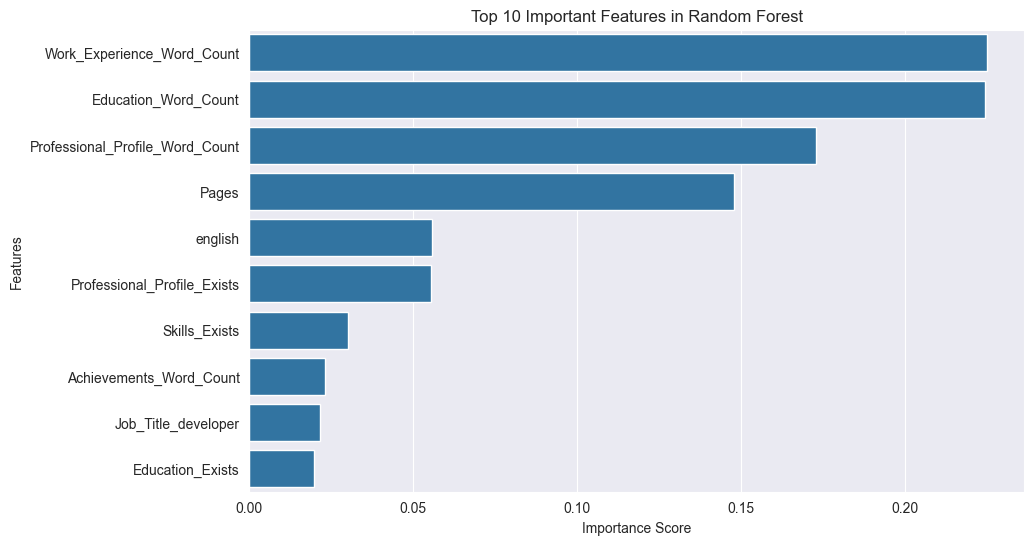

In [97]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Define function to evaluate model performance using Bayesian Optimization
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 69
    }
    rf = RandomForestClassifier(**params)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean()  # Use mean AUC score
    return score

# Define the parameter bounds for Bayesian Optimization
pbounds = {
    'n_estimators': (300, 1200),
    'max_depth': (5, 20),
    'min_samples_split': (2, 15),
    'min_samples_leaf': (1, 6)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=pbounds,
    random_state=69,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=50)  # 10 random points, 50 optimization steps

# Extract the best parameters
best_params = optimizer.max['params']
print("🔹 Best Parameters Found:", best_params)

# Train the best Random Forest Model
best_rf = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=69
)
best_rf.fit(X_train, y_train)  # Train model

# Predict on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Model Evaluation
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🔹 AUC-ROC Score: {auc_roc:.4f}")

print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n🔹 Top 10 Feature Importance:\n", feature_importances.head(10))

# Plot Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Important Features in Random Forest")
plt.show()


#### Ajustes
El recall es muy malo balanceamos el best_rf

In [99]:
best_rf = RandomForestClassifier(
    n_estimators=1009, max_depth=15,
    min_samples_split=5, min_samples_leaf=5,
    class_weight={0:1, 1:3},  # ⚡ Give more weight to "Passed" CVs
    random_state=69
)

best_rf.fit(X_train, y_train)  # Train model

# Predict on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Model Evaluation
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🔹 AUC-ROC Score: {auc_roc:.4f}")

print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n🔹 Top 10 Feature Importance:\n", feature_importances.head(10))


🔹 AUC-ROC Score: 0.6396

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.18      0.29        38
           1       0.38      0.83      0.52        23

    accuracy                           0.43        61
   macro avg       0.51      0.51      0.40        61
weighted avg       0.54      0.43      0.37        61


🔹 Top 10 Feature Importance:
 Education_Word_Count               0.228950
Work_Experience_Word_Count         0.220089
Professional_Profile_Word_Count    0.154409
Pages                              0.145853
english                            0.058011
Professional_Profile_Exists        0.055619
Skills_Exists                      0.033989
Job_Title_developer                0.027068
Achievements_Word_Count            0.026548
Education_Exists                   0.021543
dtype: float64
